### ***EDA***
- Exploring the data to gain a better understanding of it, before model building

#### ***Exploration Ideas***
- Summary stats
- Basic time series graph to see variation in precipitation over time
- Visualisation of seasonality
- Monthly / Seasonal Averages between decades -> is there a change in precip seasonality and overall levels over long periods of time?
- Correlations between last year overall precipitation and plastic pollution recorded

#### ***Packages***


In [40]:
import pickle as pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

##### ***Grabbing Dataframes***

In [41]:
ts_df = pd.read_pickle(r'C:\\Users\\liamr\\OneDrive\\Documents\\Playground\\river_plastic_data\\data\\ts_df.pkl')
plastic_pollution = pd.read_pickle(r'C:\\Users\\liamr\\OneDrive\\Documents\\Playground\\river_plastic_data\\data\\SE_top_10_pts.pkl')

In [42]:
ts_df

,river_ID,country,lon,lat,year,month,avg_precipitation
0,1,Malaysia,101.38875,3.00292,1960,1,263.625
1,2,Vietnam,106.74708,10.49875,1960,1,4.725
2,3,Thailand,100.55795,13.61573,1960,1,4.750
3,4,Myanmar,96.19083,16.77458,1960,1,7.125
4,5,Malaysia,110.39875,1.55542,1960,1,717.250
...,...,...,...,...,...,...,...
7195,6,Malaysia,101.41125,2.80458,2019,12,30.000
7196,7,Myanmar,96.10625,16.84125,2019,12,32.000
7197,8,Malaysia,102.24458,6.18208,2019,12,29.500
7198,9,Malaysia,103.34292,3.80625,2019,12,30.000


In [43]:
plastic_pollution.index = np.arange(1, len(plastic_pollution) + 1)
plastic_pollution['river_ID'] = plastic_pollution.index

# shift column 'Name' to first position 
first_column = plastic_pollution.pop('river_ID') 
  
# insert column
plastic_pollution.insert(0, 'river_ID', first_column) 

plastic_pollution

,river_ID,pollution_volume,geometry,lat,lon,rank,country
1,1,12816.00,POINT (101.38875 3.00292),3.00292,101.38875,1,Malaysia
2,2,4127.44,POINT (106.74708 10.49875),10.49875,106.74708,2,Vietnam
3,3,4027.33,POINT (100.55795 13.61573),13.61573,100.55795,3,Thailand
4,4,3615.39,POINT (96.19083 16.77458),16.77458,96.19083,4,Myanmar
5,5,3274.70,POINT (110.39875 1.55542),1.55542,110.39875,5,Malaysia
6,6,2829.21,POINT (101.41125 2.80458),2.80458,101.41125,6,Malaysia
7,7,2488.62,POINT (96.10625 16.84125),16.84125,96.10625,7,Myanmar
8,8,2466.92,POINT (102.24458 6.18208),6.18208,102.24458,8,Malaysia
9,9,2186.88,POINT (103.34292 3.80625),3.80625,103.34292,9,Malaysia
10,10,2143.48,POINT (103.7975 1.49625),1.49625,103.79750,10,Malaysia


##### ***Cleaning***

- Removing the first decade due to inconsistency, likely to do with how WorldClim collect / processed the data

In [44]:
ts_df = ts_df[ts_df['year'] >= 1970]

In [45]:
# modify the dataframe by adding a column for month-year
ts_df['year_month'] = ts_df['year'].astype(str) + '-' + ts_df['month'].astype(str)

C:\Users\liamr\AppData\Local\Temp\ipykernel_19220\3090071547.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [46]:
ts_df.info()

# convert year_month to string format
ts_df['year_month'] = ts_df['year_month'].astype(str)


ts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 1200 to 7199
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   river_ID           6000 non-null   int64  
 1   country            6000 non-null   object 
 2   lon                6000 non-null   float64
 3   lat                6000 non-null   float64
 4   year               6000 non-null   int64  
 5   month              6000 non-null   int64  
 6   avg_precipitation  6000 non-null   float32
 7   year_month         6000 non-null   object 
dtypes: float32(1), float64(2), int64(3), object(2)
memory usage: 398.4+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 1200 to 7199
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   river_ID           6000 non-null   int64  
 1   country            6000 non-null   object 
 2   lon                6000 non-null   floa

C:\Users\liamr\AppData\Local\Temp\ipykernel_19220\2745951065.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
ts_df.head()

,river_ID,country,lon,lat,year,month,avg_precipitation,year_month
1200,1,Malaysia,101.38875,3.00292,1970,1,30.50,1970-1
1201,2,Vietnam,106.74708,10.49875,1970,1,29.25,1970-1
1202,3,Thailand,100.55795,13.61573,1970,1,32.00,1970-1
1203,4,Myanmar,96.19083,16.77458,1970,1,32.00,1970-1
1204,5,Malaysia,110.39875,1.55542,1970,1,29.50,1970-1


In [48]:
# checking avg_precipitation_all_rivers_per_year is correct
ts_df[(ts_df['year_month'] >= '1990-12') & 
                 (ts_df['year_month'] <= '1991-01')]


,river_ID,country,lon,lat,year,month,avg_precipitation,year_month
3610,1,Malaysia,101.38875,3.00292,1990,2,32.00,1990-2
3611,2,Vietnam,106.74708,10.49875,1990,2,31.25,1990-2
3612,3,Thailand,100.55795,13.61573,1990,2,33.00,1990-2
3613,4,Myanmar,96.19083,16.77458,1990,2,34.75,1990-2
3614,5,Malaysia,110.39875,1.55542,1990,2,30.25,1990-2
...,...,...,...,...,...,...,...,...
3715,6,Malaysia,101.41125,2.80458,1990,12,30.00,1990-12
3716,7,Myanmar,96.10625,16.84125,1990,12,32.50,1990-12
3717,8,Malaysia,102.24458,6.18208,1990,12,29.00,1990-12
3718,9,Malaysia,103.34292,3.80625,1990,12,29.00,1990-12


In [49]:
# modify the dataframe by adding a column which averages the avg_precipitation across months 1-12 for each separate year
ts_df['avg_precipitation_all_rivers_per_year'] = ts_df.groupby(['year'])['avg_precipitation'].transform('mean')

# modify the dataframe by adding a column which averages the avg_precipitation across rivers 1-10 for each separate month
ts_df['avg_precipitation_all_rivers_per_month'] = ts_df.groupby(['year_month'])['avg_precipitation'].transform('mean')


C:\Users\liamr\AppData\Local\Temp\ipykernel_19220\741173273.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\liamr\AppData\Local\Temp\ipykernel_19220\741173273.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



##### ***Summary Stats***

In [50]:
ts_summary_stats = ts_df.describe()
print(ts_summary_stats)

          river_ID          lon          lat         year       month  \
count  6000.000000  6000.000000  6000.000000  6000.000000  6000.00000   
mean      5.500000   102.218586     7.657781  1994.500000     6.50000   
std       2.872521     4.110972     5.903516    14.432072     3.45234   
min       1.000000    96.106250     1.496250  1970.000000     1.00000   
25%       3.000000   100.557950     2.804580  1982.000000     3.75000   
50%       5.500000   101.827915     4.994165  1994.500000     6.50000   
75%       8.000000   103.797500    13.615730  2007.000000     9.25000   
max      10.000000   110.398750    16.841250  2019.000000    12.00000   

       avg_precipitation  avg_precipitation_all_rivers_per_year  \
count        6000.000000                            6000.000000   
mean           31.462126                              31.462126   
std             1.654789                               0.361322   
min            27.000000                              30.727083   
25%    

In [51]:
pollution_summary_stats = plastic_pollution.describe()
print(pollution_summary_stats)

       river_ID  pollution_volume        lat         lon      rank
count  10.00000         10.000000  10.000000   10.000000  10.00000
mean    5.50000       3997.597000   7.657781  102.218586   5.50000
std     3.02765       3182.455284   6.222334    4.332984   3.02765
min     1.00000       2143.480000   1.496250   96.106250   1.00000
25%     3.25000       2472.345000   2.854165  100.765650   3.25000
50%     5.50000       3051.955000   4.994165  101.827915   5.50000
75%     7.75000       3924.345000  12.836485  103.683855   7.75000
max    10.00000      12816.000000  16.841250  110.398750  10.00000


#### Precipitation Data
- Plot precipitation trends over time
    - Is there seasonality?
    - Are there long term trends?

## ***Trend Analysis***

### ***Long-Term Trends | All Rivers | Annual Precipitation***

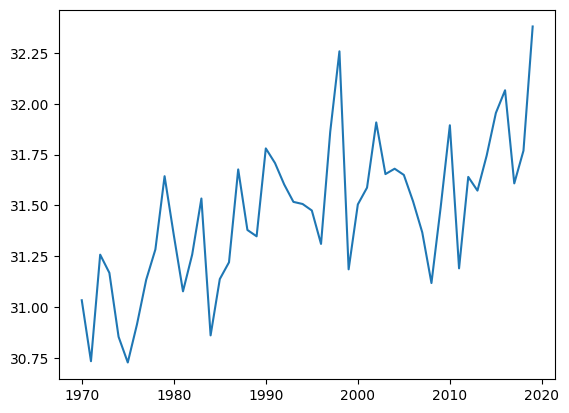

In [52]:
# using matplotlib
plt.plot(ts_df['year'],ts_df['avg_precipitation_all_rivers_per_year'])
plt.show()

In [53]:
# using plotly
fig = px.line(ts_df, x="year", y="avg_precipitation_all_rivers_per_year")
fig.show()


### ***Since 2010 | All Rivers | Annual Precipitation***

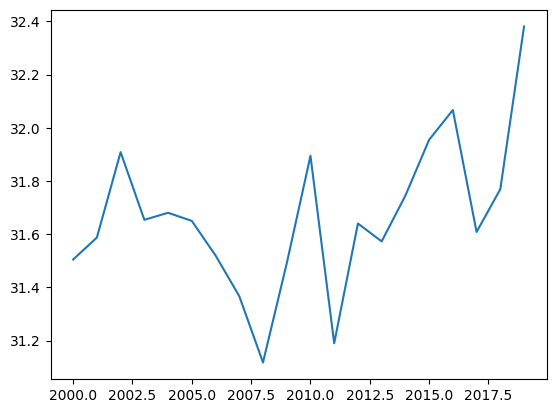

In [54]:
# using matplotlib since 2000
ts_df_2000 = ts_df[ts_df['year'] >= 2000]

plt.plot(ts_df_2000['year'], ts_df_2000['avg_precipitation_all_rivers_per_year'])
plt.show()

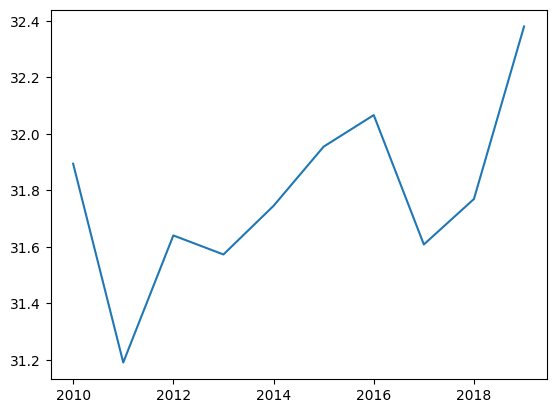

In [55]:
# using matplotlib since 2010
ts_df_2010 = ts_df[ts_df['year'] >= 2010]

plt.plot(ts_df_2010['year'], ts_df_2010['avg_precipitation_all_rivers_per_year'])
plt.show()

In [56]:
# using plotly since 2000
fig = px.line(ts_df_2000, x="year", y="avg_precipitation_all_rivers_per_year")   
fig.show()

In [57]:
# using plotly
fig = px.line(ts_df_2010, x="year", y="avg_precipitation_all_rivers_per_year")   
fig.show()

### **Trend Analysis Summary:**
- There is a clear upward trend since 1970 up until 2019
- Can see from the graphs that the trend has been relatively stable since 2000
    - Therefore this is a good period to use in my analysis when averaging precipitation levels across all years

##### **For analysis:** Will average the precipitation data from 2000-2019 for each month across the years

## ***Seasonality Analysis***

In [58]:
# 2019 precipitation
ts_df_2019 = ts_df[ts_df['year'] == 2019]
fig1 = px.line(ts_df_2019, x="year_month", y="avg_precipitation_all_rivers_per_month")   

# 2010 precipitation
ts_df_2010 = ts_df[ts_df['year'] == 2010]
fig2 = px.line(ts_df_2010, x="year_month", y="avg_precipitation_all_rivers_per_month")   

# 2000 precipitation
ts_df_2000 = ts_df[ts_df['year'] == 2000]
fig3 = px.line(ts_df_2010, x="year_month", y="avg_precipitation_all_rivers_per_month") 

# 1990 precipitation
ts_df_1990 = ts_df[ts_df['year'] == 1990]
fig4 = px.line(ts_df_1990, x="year_month", y="avg_precipitation_all_rivers_per_month") 

# 1980 precipitation
ts_df_1980 = ts_df[ts_df['year'] == 1980]
fig5 = px.line(ts_df_1980, x="year_month", y="avg_precipitation_all_rivers_per_month")

# 1970 precipitation
ts_df_1970 = ts_df[ts_df['year'] == 1970]
fig6 = px.line(ts_df_1970, x="year_month", y="avg_precipitation_all_rivers_per_month")

# make subplots
fig = make_subplots(rows=3, cols=2, subplot_titles=("2019", "2010", "2000", "1990", "1980", "1970"))
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)
fig.add_trace(fig3.data[0], row=2, col=1)
fig.add_trace(fig4.data[0], row=2, col=2)
fig.add_trace(fig5.data[0], row=3, col=1)
fig.add_trace(fig6.data[0], row=3, col=2)
# add title to the figure
fig.update_layout(title_text="Precipitation by Month - All Rivers", title_x=0.5)
fig.show()

In [59]:
# show a column plot with month on x axis and average precipitation on y axis


- There is clear seasonality consistent through the whole time period
- Significantly more rain in Feb-June period

### Clear evidence of seasonality

- Create an average monthly precipitation profile for each river by aggregating precipitation data across all years (this will be your seasonal baseline).
- Normalize monthly precipitation to derive P(M) for each river.

##### Implications for modelling:

- The normalized P(M) will serve as a key input for your model to distribute the annual plastic pollution figure across the months
- Seasonal patterns (e.g., monsoons, dry seasons) will directly reflect in the predicted monthly plastic pollution estimates

## Profiles of each river:
- Find the precipitation values for each year and average them over the 2000-2019 period
- Use annual plastic pollution values for each river, from the Ocean cleanup
- **Visualize the correlations:**
    - Scatter graphs and correlation matrices

In [60]:
# Initialize scaler
scaler = MinMaxScaler()

# Apply scaling to precipitation per river
ts_df['normalized_precipitation'] = ts_df.groupby('river_ID')['avg_precipitation'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)



C:\Users\liamr\AppData\Local\Temp\ipykernel_19220\1587449181.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Using non-normalized precipitation values...

In [61]:
# Aggregate the yearly precipitation values for each river and average them over the 2000-2019 period
river_1 = ts_df.query("river_ID == 1 and year >= 2000")
river_1 = river_1.groupby('year')['avg_precipitation'].mean()
# find the average of all the years in river_1
avg_precip_river_1 = river_1.mean()

river_2 = ts_df.query("river_ID == 2 and year >= 2000")
river_2 = river_2.groupby('year')['avg_precipitation'].mean()
avg_precip_river_2 = river_2.mean()

# repeat the code for rivers 3-10  
river_3 = ts_df.query("river_ID == 3 and year >= 2000")
river_3 = river_3.groupby('year')['avg_precipitation'].mean()
avg_precip_river_3 = river_3.mean()

# repeat the code for rivers 4-10  
river_4 = ts_df.query("river_ID == 4 and year >= 2000")
river_4 = river_4.groupby('year')['avg_precipitation'].mean()
avg_precip_river_4 = river_4.mean()

river_5 = ts_df.query("river_ID == 5 and year >= 2000")
river_5 = river_5.groupby('year')['avg_precipitation'].mean()
avg_precip_river_5 = river_5.mean()

river_6 = ts_df.query("river_ID == 6 and year >= 2000")
river_6 = river_6.groupby('year')['avg_precipitation'].mean()
avg_precip_river_6 = river_6.mean()

river_7 = ts_df.query("river_ID == 7 and year >= 2000")
river_7 = river_7.groupby('year')['avg_precipitation'].mean()
avg_precip_river_7 = river_7.mean()

river_8 = ts_df.query("river_ID == 8 and year >= 2000")
river_8 = river_8.groupby('year')['avg_precipitation'].mean()
avg_precip_river_8 = river_8.mean()

river_9 = ts_df.query("river_ID == 9 and year >= 2000") 
river_9 = river_9.groupby('year')['avg_precipitation'].mean()
avg_precip_river_9 = river_9.mean()

river_10 = ts_df.query("river_ID == 10 and year >= 2000")
river_10 = river_10.groupby('year')['avg_precipitation'].mean()
avg_precip_river_10 = river_10.mean()

# put all these averages into a dataframe
df_avg_precip = pd.DataFrame({'river_ID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                   'avg_precip_river': [avg_precip_river_1, 
                                        avg_precip_river_2, 
                                        avg_precip_river_3, 
                                        avg_precip_river_4, 
                                        avg_precip_river_5, 
                                        avg_precip_river_6, 
                                        avg_precip_river_7, 
                                        avg_precip_river_8, 
                                        avg_precip_river_9, 
                                        avg_precip_river_10]})

df_avg_precip

,river_ID,avg_precip_river
0,1,31.795834
1,2,31.095835
2,3,32.706245
3,4,32.603127
4,5,31.692709
5,6,31.141668
6,7,32.728127
7,8,31.064587
8,9,31.174999
9,10,30.648960


#### Using normalized precipitation values...

In [62]:
# Aggregate the yearly precipitation values for each river and average them over the 2000-2019 period
river_1 = ts_df.query("river_ID == 1 and year >= 2000")
river_1 = river_1.groupby('year')['normalized_precipitation'].mean()
# find the average of all the years in river_1
avg_precip_river_1 = river_1.mean()

river_2 = ts_df.query("river_ID == 2 and year >= 2000")
river_2 = river_2.groupby('year')['normalized_precipitation'].mean()
avg_precip_river_2 = river_2.mean()

# repeat the code for rivers 3-10  
river_3 = ts_df.query("river_ID == 3 and year >= 2000")
river_3 = river_3.groupby('year')['normalized_precipitation'].mean()
avg_precip_river_3 = river_3.mean()

# repeat the code for rivers 4-10  
river_4 = ts_df.query("river_ID == 4 and year >= 2000")
river_4 = river_4.groupby('year')['normalized_precipitation'].mean()
avg_precip_river_4 = river_4.mean()

river_5 = ts_df.query("river_ID == 5 and year >= 2000")
river_5 = river_5.groupby('year')['normalized_precipitation'].mean()
avg_precip_river_5 = river_5.mean()

river_6 = ts_df.query("river_ID == 6 and year >= 2000")
river_6 = river_6.groupby('year')['normalized_precipitation'].mean()
avg_precip_river_6 = river_6.mean()

river_7 = ts_df.query("river_ID == 7 and year >= 2000")
river_7 = river_7.groupby('year')['normalized_precipitation'].mean()
avg_precip_river_7 = river_7.mean()

river_8 = ts_df.query("river_ID == 8 and year >= 2000")
river_8 = river_8.groupby('year')['normalized_precipitation'].mean()
avg_precip_river_8 = river_8.mean()

river_9 = ts_df.query("river_ID == 9 and year >= 2000") 
river_9 = river_9.groupby('year')['normalized_precipitation'].mean()
avg_precip_river_9 = river_9.mean()

river_10 = ts_df.query("river_ID == 10 and year >= 2000")
river_10 = river_10.groupby('year')['normalized_precipitation'].mean()
avg_precip_river_10 = river_10.mean()

# put all these averages into a dataframe
df_avg_precip_normalized = pd.DataFrame({'river_ID': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                   'avg_precip_river': [avg_precip_river_1, 
                                        avg_precip_river_2, 
                                        avg_precip_river_3, 
                                        avg_precip_river_4, 
                                        avg_precip_river_5, 
                                        avg_precip_river_6, 
                                        avg_precip_river_7, 
                                        avg_precip_river_8, 
                                        avg_precip_river_9, 
                                        avg_precip_river_10]})

df_avg_precip_normalized

,river_ID,avg_precip_river
0,1,0.588596
1,2,0.553205
2,3,0.494531
3,4,0.375915
4,5,0.598732
5,6,0.628334
6,7,0.355060
7,8,0.580655
8,9,0.695834
9,10,0.588657


In [63]:
plastic_pollution

,river_ID,pollution_volume,geometry,lat,lon,rank,country
1,1,12816.00,POINT (101.38875 3.00292),3.00292,101.38875,1,Malaysia
2,2,4127.44,POINT (106.74708 10.49875),10.49875,106.74708,2,Vietnam
3,3,4027.33,POINT (100.55795 13.61573),13.61573,100.55795,3,Thailand
4,4,3615.39,POINT (96.19083 16.77458),16.77458,96.19083,4,Myanmar
5,5,3274.70,POINT (110.39875 1.55542),1.55542,110.39875,5,Malaysia
6,6,2829.21,POINT (101.41125 2.80458),2.80458,101.41125,6,Malaysia
7,7,2488.62,POINT (96.10625 16.84125),16.84125,96.10625,7,Myanmar
8,8,2466.92,POINT (102.24458 6.18208),6.18208,102.24458,8,Malaysia
9,9,2186.88,POINT (103.34292 3.80625),3.80625,103.34292,9,Malaysia
10,10,2143.48,POINT (103.7975 1.49625),1.49625,103.79750,10,Malaysia


### Correlations between Average Precipitation and Pollution

In [64]:
# merge the two dataframes

# non-normalized
average_rain_and_pollution = pd.merge(df_avg_precip, plastic_pollution, on='river_ID', how='outer')

# normalized
average_rain_and_pollution_normalized = pd.merge(df_avg_precip_normalized, plastic_pollution, on='river_ID', how='outer')

In [65]:
average_rain_and_pollution

,river_ID,avg_precip_river,pollution_volume,geometry,lat,lon,rank,country
0,1,31.795834,12816.00,POINT (101.38875 3.00292),3.00292,101.38875,1,Malaysia
1,2,31.095835,4127.44,POINT (106.74708 10.49875),10.49875,106.74708,2,Vietnam
2,3,32.706245,4027.33,POINT (100.55795 13.61573),13.61573,100.55795,3,Thailand
3,4,32.603127,3615.39,POINT (96.19083 16.77458),16.77458,96.19083,4,Myanmar
4,5,31.692709,3274.70,POINT (110.39875 1.55542),1.55542,110.39875,5,Malaysia
5,6,31.141668,2829.21,POINT (101.41125 2.80458),2.80458,101.41125,6,Malaysia
6,7,32.728127,2488.62,POINT (96.10625 16.84125),16.84125,96.10625,7,Myanmar
7,8,31.064587,2466.92,POINT (102.24458 6.18208),6.18208,102.24458,8,Malaysia
8,9,31.174999,2186.88,POINT (103.34292 3.80625),3.80625,103.34292,9,Malaysia
9,10,30.648960,2143.48,POINT (103.7975 1.49625),1.49625,103.79750,10,Malaysia


In [66]:
average_rain_and_pollution_normalized

,river_ID,avg_precip_river,pollution_volume,geometry,lat,lon,rank,country
0,1,0.588596,12816.00,POINT (101.38875 3.00292),3.00292,101.38875,1,Malaysia
1,2,0.553205,4127.44,POINT (106.74708 10.49875),10.49875,106.74708,2,Vietnam
2,3,0.494531,4027.33,POINT (100.55795 13.61573),13.61573,100.55795,3,Thailand
3,4,0.375915,3615.39,POINT (96.19083 16.77458),16.77458,96.19083,4,Myanmar
4,5,0.598732,3274.70,POINT (110.39875 1.55542),1.55542,110.39875,5,Malaysia
5,6,0.628334,2829.21,POINT (101.41125 2.80458),2.80458,101.41125,6,Malaysia
6,7,0.355060,2488.62,POINT (96.10625 16.84125),16.84125,96.10625,7,Myanmar
7,8,0.580655,2466.92,POINT (102.24458 6.18208),6.18208,102.24458,8,Malaysia
8,9,0.695834,2186.88,POINT (103.34292 3.80625),3.80625,103.34292,9,Malaysia
9,10,0.588657,2143.48,POINT (103.7975 1.49625),1.49625,103.79750,10,Malaysia


#### Non-Normalized...

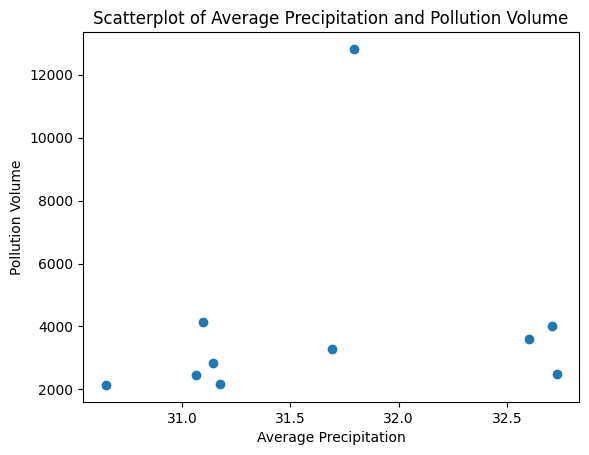

In [67]:
# scatterplot between rainfall and pollution
plt.scatter(average_rain_and_pollution['avg_precip_river'], average_rain_and_pollution['pollution_volume'])
plt.xlabel('Average Precipitation')
plt.ylabel('Pollution Volume')
plt.title('Scatterplot of Average Precipitation and Pollution Volume')
plt.show()

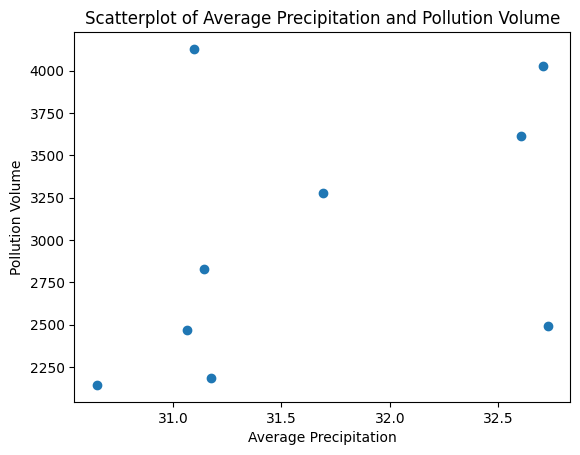

In [68]:
# take out the outlier river 1 from the scatterplot
average_rain_and_pollution_no_outlier = average_rain_and_pollution[average_rain_and_pollution['river_ID'] != 1]
plt.scatter(average_rain_and_pollution_no_outlier['avg_precip_river'], average_rain_and_pollution_no_outlier['pollution_volume'])
plt.xlabel('Average Precipitation')
plt.ylabel('Pollution Volume')
plt.title('Scatterplot of Average Precipitation and Pollution Volume')
plt.show()

#### Normalized...

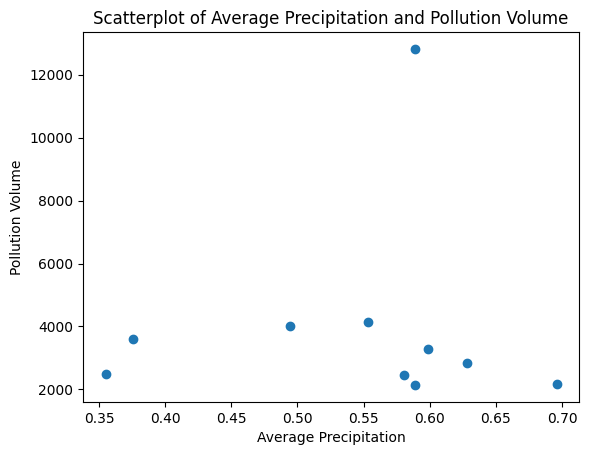

In [69]:
# with normalized precipitation averages
plt.scatter(average_rain_and_pollution_normalized['avg_precip_river'], average_rain_and_pollution_normalized['pollution_volume'])
plt.xlabel('Average Precipitation')
plt.ylabel('Pollution Volume')
plt.title('Scatterplot of Average Precipitation and Pollution Volume')
plt.show()

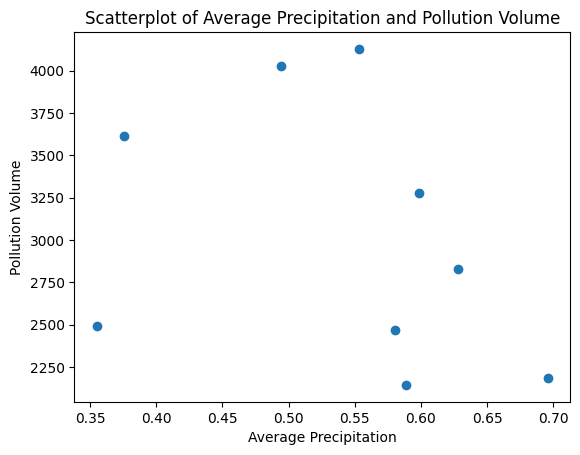

In [70]:
normalized_average_rain_and_pollution_no_outlier = average_rain_and_pollution_normalized[average_rain_and_pollution_normalized['river_ID'] != 1]
plt.scatter(normalized_average_rain_and_pollution_no_outlier['avg_precip_river'], normalized_average_rain_and_pollution_no_outlier['pollution_volume'])
plt.xlabel('Average Precipitation')
plt.ylabel('Pollution Volume')
plt.title('Scatterplot of Average Precipitation and Pollution Volume')
plt.show()


#### Non-Normalized figures correlation coefficients:

In [71]:
# pearson correlation coefficient
corr, p_value = pearsonr(average_rain_and_pollution_no_outlier['avg_precip_river'], 
                          average_rain_and_pollution_no_outlier['pollution_volume'])
print(f"Spearman Correlation: {corr}, P-Value: {p_value}")

Spearman Correlation: 0.4275794632621116, P-Value: 0.2509749559473871


In [72]:
# spearman correlation coefficient
corr, p_value = spearmanr(average_rain_and_pollution_no_outlier['avg_precip_river'], 
                          average_rain_and_pollution_no_outlier['pollution_volume'])
print(f"Spearman Correlation: {corr}, P-Value: {p_value}")

Spearman Correlation: 0.39999999999999997, P-Value: 0.2861051019083129


#### Normalized figures correlation coefficients:

In [73]:
# pearson correlation coefficient
corr, p_value = pearsonr(normalized_average_rain_and_pollution_no_outlier['avg_precip_river'], 
                          normalized_average_rain_and_pollution_no_outlier['pollution_volume'])
print(f"Spearman Correlation: {corr}, P-Value: {p_value}")

Spearman Correlation: -0.3253757477793763, P-Value: 0.3928790151300067


In [74]:
# spearman correlation coefficient
corr, p_value = spearmanr(normalized_average_rain_and_pollution_no_outlier['avg_precip_river'], 
                          normalized_average_rain_and_pollution_no_outlier['pollution_volume'])
print(f"Spearman Correlation: {corr}, P-Value: {p_value}")

Spearman Correlation: -0.43333333333333335, P-Value: 0.24395243588005167


- There does appear to be some correlation between average precipitation levels and pollution volume, especially in the non-normalized values

In [75]:
ts_df.to_pickle('C:\\Users\\liamr\\OneDrive\\Documents\\Playground\\river_plastic_data\\data\\ts_df_clean.pkl')
average_rain_and_pollution.to_pickle('C:\\Users\\liamr\\OneDrive\\Documents\\Playground\\river_plastic_data\\data\\average_rain_and_pollution.pkl')
average_rain_and_pollution_normalized.to_pickle('C:\\Users\\liamr\\OneDrive\\Documents\\Playground\\river_plastic_data\\data\\average_rain_and_pollution_normalized.pkl')

In [76]:
average_rain_and_pollution.head()

,river_ID,avg_precip_river,pollution_volume,geometry,lat,lon,rank,country
0,1,31.795834,12816.00,POINT (101.38875 3.00292),3.00292,101.38875,1,Malaysia
1,2,31.095835,4127.44,POINT (106.74708 10.49875),10.49875,106.74708,2,Vietnam
2,3,32.706245,4027.33,POINT (100.55795 13.61573),13.61573,100.55795,3,Thailand
3,4,32.603127,3615.39,POINT (96.19083 16.77458),16.77458,96.19083,4,Myanmar
4,5,31.692709,3274.70,POINT (110.39875 1.55542),1.55542,110.39875,5,Malaysia


In [77]:
average_rain_and_pollution_normalized.head()

,river_ID,avg_precip_river,pollution_volume,geometry,lat,lon,rank,country
0,1,0.588596,12816.00,POINT (101.38875 3.00292),3.00292,101.38875,1,Malaysia
1,2,0.553205,4127.44,POINT (106.74708 10.49875),10.49875,106.74708,2,Vietnam
2,3,0.494531,4027.33,POINT (100.55795 13.61573),13.61573,100.55795,3,Thailand
3,4,0.375915,3615.39,POINT (96.19083 16.77458),16.77458,96.19083,4,Myanmar
4,5,0.598732,3274.70,POINT (110.39875 1.55542),1.55542,110.39875,5,Malaysia
